**Introduction to Turing**

Using coin flips

In [3]:
using Random, Plots, Distributions

In [14]:
p_true = 0.5 #probability of getting heads
N = 0:100 #100 flips
Random.seed!(12)

data = rand(Bernoulli(p_true), last(N)) #draw from Bernoulli distribution
prior_belief = Beta(1,1) #prior belief of probability of getting heads

Beta{Float64}(α=1.0, β=1.0)

┌ Info: Saved animation to 
│   fn = /home/sahil/julia/learn-julia/tmp.gif
└ @ Plots /home/sahil/.julia/packages/Plots/zOV0T/src/animation.jl:104


Plots.AnimatedGif("/home/sahil/julia/learn-julia/tmp.gif")
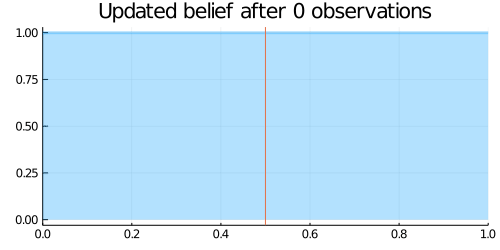

In [15]:
using StatsPlots

#The animation demonstrates that with increasing evidence our prior belief adjusts to the true probability
animation = @gif for (i, n) in enumerate(N)
    heads = sum(data[1:i-1])
    tails = n - heads
    updated_belief = Beta(prior_belief.α + heads, prior_belief.β + tails)
    plot(updated_belief, size = (500, 250), title = "Updated belief after $n observations",
        xlabel = "", ylabel = "", legend = nothing, xlim = (0,1), fill=0, α=0.3, w=3)
    vline!([p_true])
end

Note that the prior distribution had a convenient closed form expression, which not all models have. 

Enter *Turing*, a universal probabilistic programming system in Julia `(Turing.jl)`
with intuitive modeling syntex and support for many sampling-based inference algorithms

In [17]:
using Turing, MCMCChains #The Turing library and Markov Chain Monte Carlo simulations

In [18]:
# Defining the model
@model coinflip(y) = begin
    p ~ Beta(1, 1) # prior belief in probability of getting heads
    N = length(y)
    for n in 1:N
        y[n] ~ Bernoulli(p) # results of coin flip from Bernoulli distribution
    end
end;

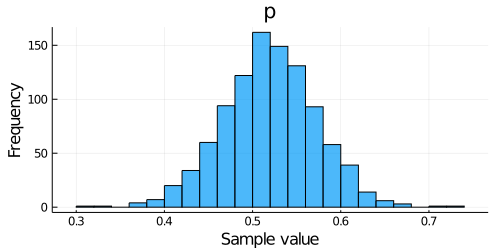

In [19]:
# Approximate the posterior distribution by drawing samples
iterations = 1000
ϵ = 0.05
τ = 10
chain = sample(coinflip(data), HMC(ϵ, τ), iterations, progress=false) # Hamiltonian Monte Carlo sampler

#Construct summary of sampling process for probability of getting heads
p_summary = chain[:p]
plot(p_summary, seriestype= :histogram)

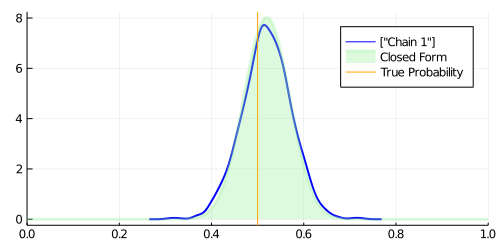

In [20]:
#Compare this to closed form solution and true probability
N = length(data)
heads = sum(data)
updated_belief = Beta(prior_belief.α + heads, prior_belief.β + (N - heads))

p = plot(p_summary, seriestype = :density, xlim=(0,1), legend = :best, w=2, c = :blue)
r = range(0, stop=1, length=100)
plot!(p, r, pdf.(Ref(updated_belief), r), xlabel="", ylabel="", title="",
      xlim=(0,1), label="Closed Form", fill=0, α=0.3, w=3, c=:lightgreen)
vline!(p, [p_true], label="True Probability", c=:orange)

**Gaussian Mixture Models**

Performing Unsupervised Learning

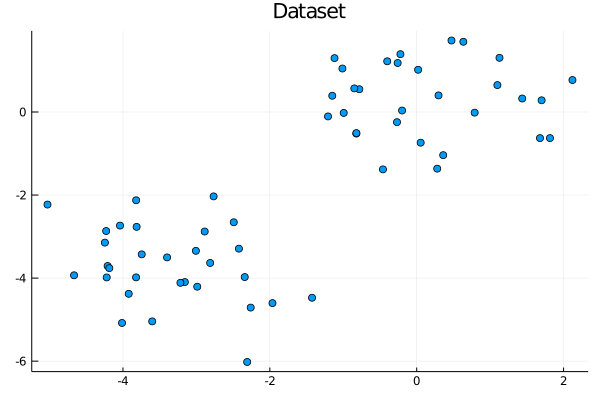

In [21]:
Random.seed!(3)
N = 30
μ = [-3.5, 0.0]

x = mapreduce(c -> rand(MvNormal([μ[c], μ[c]], 1.), N), hcat, 1:2)
scatter(x[1,:], x[2,:], legend = false, title = "Dataset")

In [26]:
Turing.turnprogress(false)

@model GaussianMixtureModel(x, draw_weights=false) = begin
    D, N = size(x)
    μ1 ~ Normal()
    μ2 ~ Normal()
    μ = [μ1, μ2]
    
    if draw_weights
        α = 1.0
        w ~ Dirichlet(2, α)
    else
        w = [0.5, 0.5]
    end
    
    #Generate assignments from multivariate normal distribution for each data point
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ Categorical(w)
        x[:, i] ~ MvNormal([μ[k[i]], μ[k[i]]], 1.)
    end
    return k
end

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /home/sahil/.julia/packages/Turing/d4vqQ/src/Turing.jl:22


DynamicPPL.ModelGen{var"###generator#556",(:x, :draw_weights),(:draw_weights,),Tuple{Bool}}(##generator#556, (draw_weights = false,))

In [27]:
gmm_model = GaussianMixtureModel(x)
# Draw observations from posterior distribution (Particle Gibbs for discrete assignment parameters, and 
# Hamiltonian Monte Carlo for continuous parameters) combine these two using a Gibbs sampler for Bayesian inference
gmm_sampler = Gibbs(PG(100, :k), HMC(0.05, 10, :μ1, :μ2)) 
# MCMC simulation with multiple chains to test for convergence
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler, 100), chainscat, 1:3);

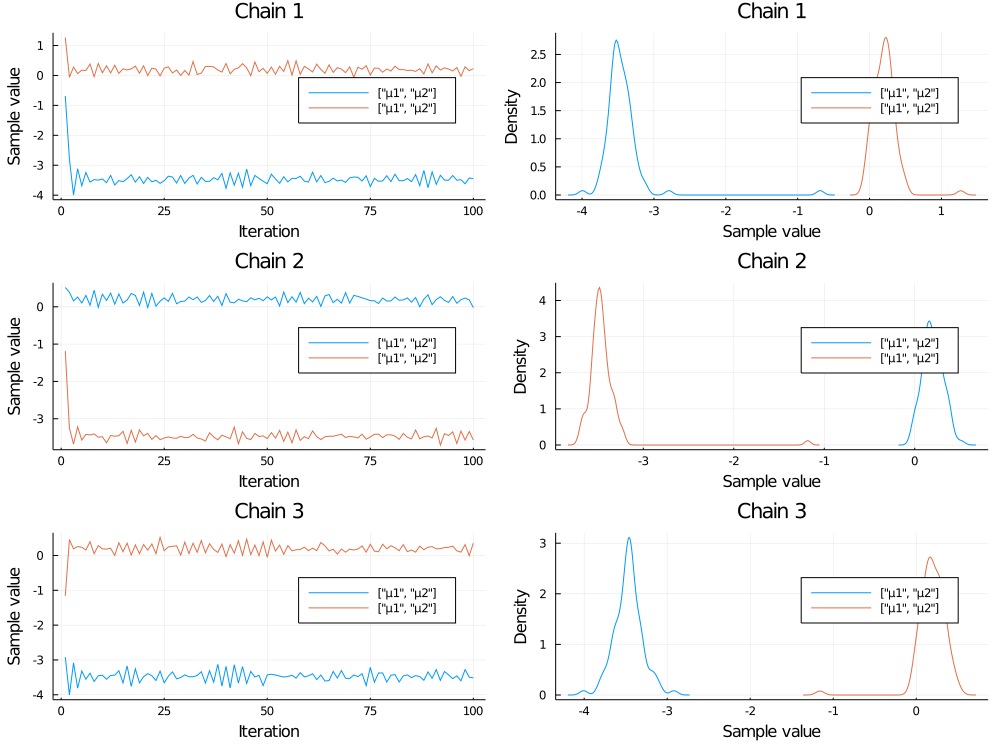

In [28]:
ids = findall(map(name -> occursin("μ", name), names(tchain)));
p=plot(tchain[:, ids, :], legend=true, labels = ["μ1", "μ2"], colordim=:parameter)

In [31]:
function predict(x, y, w, μ)
    return Turing.logaddexp(
        log(w[1]) + logpdf(MvNormal([μ[1], μ[1]], 1.), [x,y]),
        log(w[2]) + logpdf(MvNormal([μ[2], μ[2]], 1.), [x,y])
    )
end

predict (generic function with 1 method)

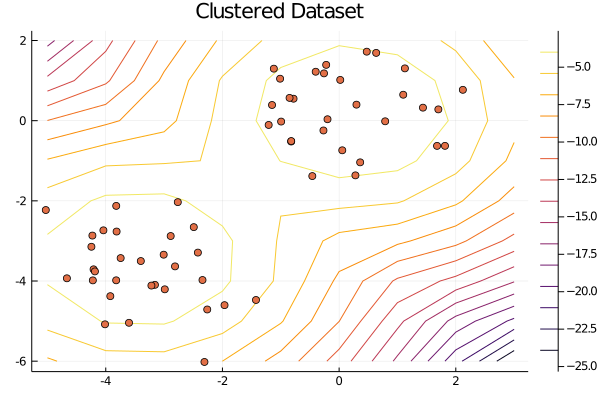

In [33]:
tchain = tchain[:, :, 1]; # Get predictions for just one chain
contour(range(-5, stop=3), range(-6, stop=2), 
    (x,y) -> predict(x, y, [0.5, 0.5], [mean(tchain[:μ1].value), mean(tchain[:μ2].value)]))
scatter!(x[1,:], x[2,:], legend=false, title="Clustered Dataset")

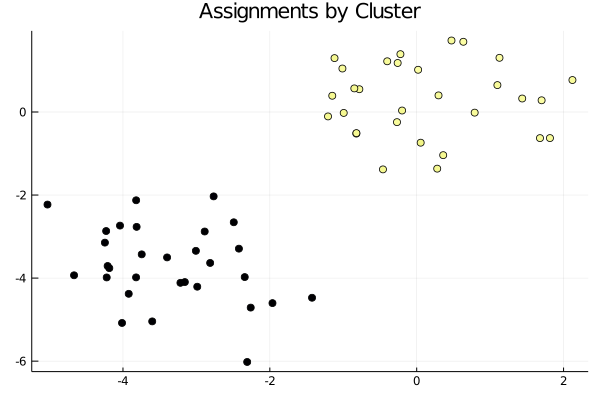

In [34]:
assignments = collect(skipmissing(mean(tchain[:k].value, dims=1).data))
scatter(x[1,:], x[2,:], legend=false, title="Assignments by Cluster", zcolor=assignments)

Let's draw weights from the Dirichlet distribution

In [35]:
gmm_model = GaussianMixtureModel(x, true)
gmm_sampler = Gibbs(PG(100, :k), HMC(0.05, 10, :μ1, :μ2))
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler, 100), chainscat, 1:3);

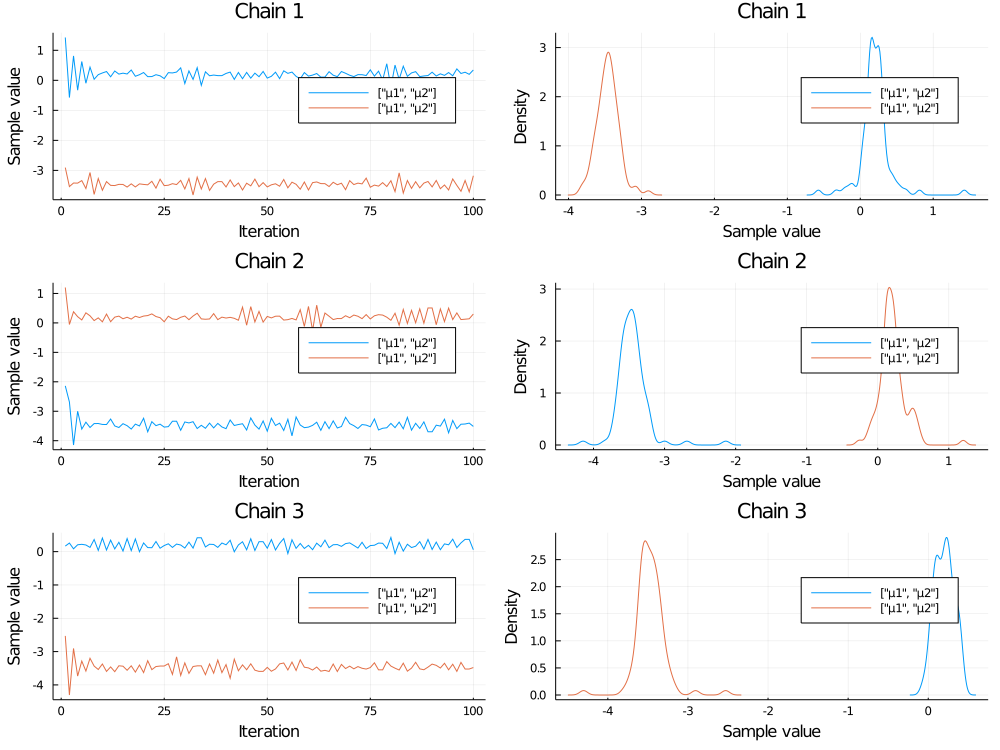

In [36]:
ids = findall(map(name -> occursin("μ", name), names(tchain)));
p=plot(tchain[:, ids, :], legend=true, labels = ["μ1", "μ2"], colordim=:parameter)

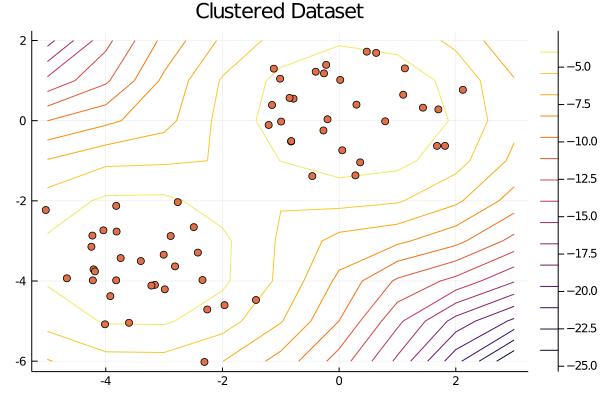

In [37]:
tchain = tchain[:, :, 1]; 
contour(range(-5, stop=3), range(-6, stop=2), 
    (x,y) -> predict(x, y, [0.5, 0.5], [mean(tchain[:μ1].value), mean(tchain[:μ2].value)]))
scatter!(x[1,:], x[2,:], legend=false, title="Clustered Dataset")

The results are essentially the same!

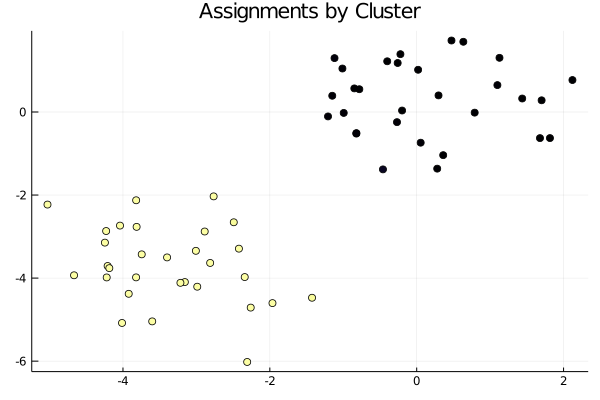

In [38]:
assignments = collect(skipmissing(mean(tchain[:k].value, dims=1).data))
scatter(x[1,:], x[2,:], legend=false, title="Assignments by Cluster", zcolor=assignments)

**Infinite Mixture Models**

Gaussian mixture models are useful when thee number of clusters is known beforehand. In the event that we do not know how many clusters are present, nonparametric models are useful. In this case we will use the Dirichlet process in a mixture of infinitely many Gaussians in the context of the Chinese restaurant process.

*Initial two component construction with finite mixture model*

In [44]:
@model two_model(x) = begin
    
    # Hyper-parameters
    μ0 = 0.0
    σ0 = 1.0
    
    # Draw weights.
    π1 ~ Beta(1,1)
    π2 = 1-π1
    
    # Draw locations of the components.
    μ1 ~ Normal(μ0, σ0)
    μ2 ~ Normal(μ0, σ0)
    
    # Draw latent assignment.
    z ~ Categorical([π1, π2])
    
    # Draw observation from selected component.
    if z == 1
        x ~ Normal(μ1, 1.0)
    else
        x ~ Normal(μ2, 1.0)
    end
end

DynamicPPL.ModelGen{var"###generator#618",(:x,),(),Tuple{}}(##generator#618, NamedTuple())

When deriving the conditional prior when k approaches infinity, we realize that the conditional prior for conditional assignments is proportional to the number of such observations, as the plot below shows. The animation also demonstrates taht the number of clusters is logarithmic to the number of observations

In [39]:
using Turing.RandomMeasures

┌ Info: Saved animation to 
│   fn = /home/sahil/julia/learn-julia/tmp.gif
└ @ Plots /home/sahil/.julia/packages/Plots/zOV0T/src/animation.jl:104


Plots.AnimatedGif("/home/sahil/julia/learn-julia/tmp.gif")
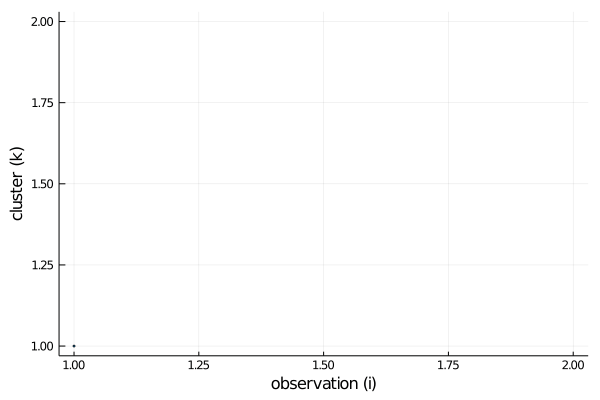

In [47]:
α = 10.0
rpm = DirichletProcess(α)

z = Vector{Int}()
Nmax = 500
for i in 1:Nmax
    K = isempty(z) ? 0 : maximum(z)
    nk = Vector{Int}(map(k -> sum(z .== k), 1:K))
    push!(z, rand(ChineseRestaurantProcess(rpm, nk)))
end

@gif for i in 1:Nmax
    scatter(collect(1:i), z[1:i], markersize=2, xlabel= "observation (i)", ylabel="cluster (k)", legend=false)
end

The Chinese restaurant process construction of a Dirichlet process is as follows:

In [52]:
@model infiniteGMM(x) = begin
    α = 1.0
    μ0 = 0.0
    σ0 = 1.0
    rpm = DirichletProcess(α) #Random Measure
    H = Normal(μ0, σ0) #Base distribution, expected value of Dirichlet process
    
    z = tzeros(Int, length(x)) #latent assignment
    μ = tzeros(Float64, 0) # locations of clusters
    for i in 1:length(x)
        K = maximum(z) # number of clusters
        nk = Vector{Int}(map(k -> sum(z .== k), 1:K))
        z[i] ~ ChineseRestaurantProcess(rpm, nk) #draw the latent assignment 
        if z[i] > K # new cluster
            push!(μ, .0)
            μ[z[i]] ~ H
        end
        x[i] ~ Normal(μ[z[i]], 1.0) # draw observation
    end
end

DynamicPPL.ModelGen{var"###generator#1156",(:x,),(),Tuple{}}(##generator#1156, NamedTuple())

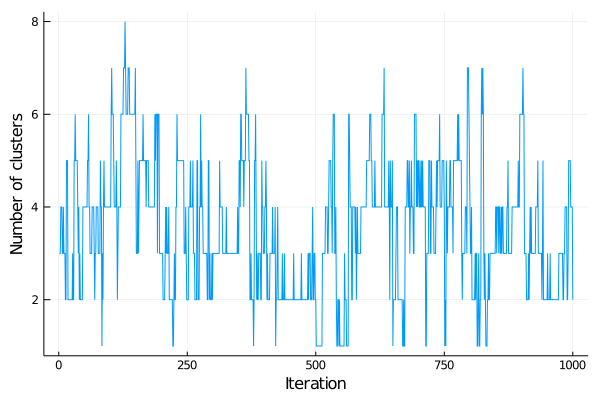

In [55]:
# Generate testing data
Random.seed!(1)
data = vcat(randn(10), randn(10) .- 5, randn(10) .+ 10) #3 clusters
data .-= mean(data)
data /= std(data);

# MCMC Sampling
Random.seed!(2)
iterations = 1000
model_func = infiniteGMM(data);
chain = sample(model_func, SMC(), iterations) #Sequential Monte Carlo

k = map(t -> length(unique(chain[:z].value[t,:,:])), 1:iterations);
plot(k, xlabel="Iteration", ylabel="Number of clusters", legend=false)

Histogram of number of clusters sampled from posterior shows that the model prefers 3 clusters, which matches the true data. This is not guaranteed to converge accurately, especially if the data does not come from a finite mixture model

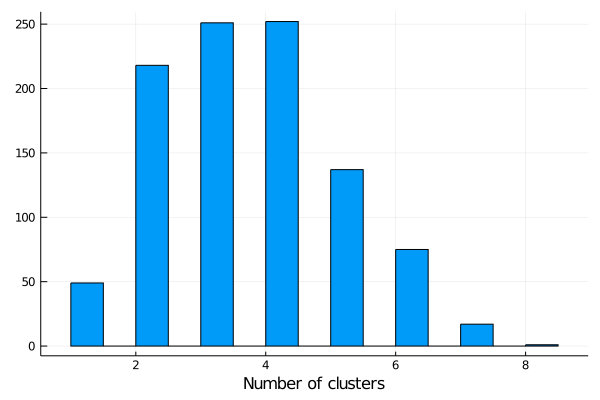

In [56]:
histogram(k, xlabel = "Number of clusters", legend=false)